# Using VAEs as a Data Augmentation Technic
## Observations
 - Slightly improves f1-scores in few-shot scenarios
 - only yields improvments when generated samples do NOT dominate the original samples, i.e. do not generate more examples than the original dataset holds!
 - for non-few-shot scenarios the augmentation leads to faster and more stable convergence but not to an overall better performance of the model
 - often the f1-scores tend to rise faster when using additional generated data espiacially in early stages of training (first ~100 steps)
 - it seems like one cannot train the VAEs enough. The longer the better, which is weird because usually this means that the generated samples are very close to the original ones used for training

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import accuracy_score, f1_score
from sklearn.decomposition import PCA
from tqdm.notebook import trange, tqdm
from pathlib import Path
import pandas as pd
import random
from torchvision.datasets import MNIST
import torchvision.utils as vutils
import torchvision.transforms as transforms

In [3]:
# set seed
model_seed = 936
data_seed =  83
# set cudnn backend to be deterministic
torch.backends.cudnn.deterministic = True
# utility function for seeding
def seed_everything(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
# for plotting
def ordering(rows, cols):
    # this permutation is used for ordering the images - for visualization purpose
    return torch.cat([torch.LongTensor([i + rows * j for j in range(cols)]) for i in range(rows)], dim=0)

## Hyperparameters

In [4]:
mix_data =                  False
# data hyperparameters
n_originals_per_class =     5
n_generated_per_class =     5000
# vae hyperparamters
vae_z_dim =                 2
vae_training_steps =        5000
vae_beta =                  0.50
vae_batch_size =            2
# gc hyperparameters
gc_training_steps =         2000
gc_batch_size =             16
gc_step_threshold =         700
# cnn model hyperparameters
cls_training_steps =        2000
cls_batch_size =            32
cls_eval_interval =         20

In [5]:
# cuda
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print("Using device:", device)
# output dir for plots
plot_dir = Path(f"../plots/MNIST/runs/{n_originals_per_class}-{n_generated_per_class}-{vae_z_dim}-{vae_training_steps}-{vae_beta}-{vae_batch_size}-{gc_training_steps}-{gc_batch_size}-{gc_step_threshold}-{cls_training_steps}-{cls_batch_size}-{cls_eval_interval}")
plot_root = Path(f"../plots/MNIST")
plot_root.mkdir(exist_ok=True, parents=True)
plot_dir.mkdir(exist_ok=True, parents=True)

Using device: cuda:0


## Data Preparation


In [6]:
# load mnist
mnist_train = MNIST(
    root="~/torch_datasets",
    transform=transforms.ToTensor(),
    train=True,
)
mnist_test = MNIST(
    root="~/torch_datasets",
    transform=transforms.ToTensor(),
    train=False,
)

# extract test data
x_test, y_test = zip(*[(x, y) for x, y in torch.utils.data.DataLoader(mnist_test, batch_size=512, num_workers=4)])
x_test, y_test = torch.cat(x_test, dim=0), torch.cat(y_test, dim=0)

# extract train data
x_train, y_train = zip(*[(x, y) for x, y in torch.utils.data.DataLoader(mnist_train, batch_size=512, num_workers=4)])
x_train, y_train = torch.cat(x_train, dim=0).numpy(), torch.cat(y_train, dim=0).numpy()

# remember the shape of the data
input_shape = x_train.shape[1:]
n_classes = len(np.unique(y_train))

# following data operations include random permutations so seed everything
seed_everything(data_seed)
# separate train data into the different classes
if mix_data:
    train_per_label = []
    for i in range(n_classes):
        class_data = x_train[y_train == i]
        other_data = x_train[y_train != i]
        train_per_label.append(np.concatenate([class_data, other_data[np.random.permutation(len(other_data))[:len(class_data) // 4]]]))
else:
    train_per_label = [x_train[y_train == i] for i in range(n_classes)]

# reduce training size
if n_originals_per_class:
    train_per_label = [X[np.random.permutation(X.shape[0])[:n_originals_per_class]] for X in train_per_label]

## Variational Auto-Encoder

In [7]:
class Encoder(nn.Sequential):
    def __init__(self, z_dim):
        self.z_dim = z_dim
        nn.Sequential.__init__(self,
            # Convolution 1 - input shape (1, 28, 28)
            nn.Conv2d(1, 32, kernel_size=4, stride=2, padding=1, bias=False),
            nn.LeakyReLU(0.2),
            nn.BatchNorm2d(32),
            # Convolution 1 - input shape (32, 14, 14)
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.LeakyReLU(0.2),
            nn.BatchNorm2d(64),
            # dense - input shape (64, 7, 7) 
            # output dimension is 2 * z-dim (concat mean and variance vectors)
            nn.Flatten(),
            nn.Linear(64 * 7 * 7, 2 * z_dim)
        )
    def forward(self, x):
        mean_variance = nn.Sequential.forward(self, x)
        mean, log_variance = mean_variance[..., :self.z_dim], mean_variance[..., self.z_dim:]
        # actually computes the log of the variance
        return mean, log_variance
class Decoder(nn.Module):
    def __init__(self, z_dim):
        nn.Module.__init__(self)
        self.linear = nn.Linear(z_dim, 64 * 7 * 7)
        self.conv = nn.Sequential(
            # transpose convolution 1 - input shape (64, 7, 7)
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            # transpose convolution 2 - input shape (32, 14, 14)
            nn.ConvTranspose2d(32, 16, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            # pixel-wise linear - input shape (16, 28, 28)
            nn.Conv2d(16, 1, kernel_size=1, stride=1, padding=0, bias=False),
            nn.Sigmoid()
            # output shape (1, 28, 28)
        )
    def forward(self, z):
        x = self.linear(z).relu()
        x = x.reshape(-1, 64, 7, 7)
        return self.conv(x)
class VAE(nn.Module):
    def __init__(self, z_dim):
        nn.Module.__init__(self)
        self.encoder = Encoder(z_dim)
        self.decoder = Decoder(z_dim)
    def forward(self, x):
        # encode
        mean, variance_log = self.encoder(x)
        # sample from encoding
        if self.training:
            eps = torch.empty_like(variance_log).normal_()
            z = eps * (variance_log / 2).exp() + mean
        else:
            # in evaluation use the mean
            z = mean
        # decode from sample
        x_ = self.decoder(z)
        return x_, mean, variance_log
    @classmethod
    def from_state_dict(cls, z_dim, state_dict):
        vae = cls(z_dim)
        vae.load_state_dict(state_dict)
        return vae.eval()

### Training the VAE Models

In [8]:
# seed, so vae initialization is reproducable
seed_everything(model_seed)
# create one VAE model for each class
vae_per_label = [VAE(z_dim=vae_z_dim) for _ in range(n_classes)]

# save early version of vae for generative classifier training
early_vae_per_label = []

seed_everything(data_seed)
# train each vae on the specific data
for k, (X, vae) in enumerate(zip(train_per_label, vae_per_label)):
    early_vaes = []
    r_losses, kl_losses = [], []
    X = torch.FloatTensor(X)
    # move vae to device and set it to train mode
    # also create an optimizer
    vae.to(device).train()
    optim = torch.optim.Adam(vae.parameters(), weight_decay=0.01)
    t = trange(vae_training_steps, leave=False)
    for i in t:
        # get batch to train from
        x_idx = np.random.randint(0, n_originals_per_class, vae_batch_size)
        x = X[x_idx].to(device)
        # predict and compute loss
        x_, m, v_log = vae(x)
        r_l = F.binary_cross_entropy(x_, x) * 28 * 28
        kl_l = vae_beta * (v_log.exp() + m**2 - 1 - v_log).sum(-1).mean()
        # update parameters
        optim.zero_grad()
        (r_l + kl_l).backward()
        optim.step()
        # update losses
        r_losses.append(r_l.item())
        kl_losses.append(kl_l.item())
        # update progress bar
        t.set_postfix({'r-loss': np.average(r_losses[-5:]), 'kl-loss': np.average(kl_losses[-5:])})
        
        if i % 50 == 0 and i <= 800 and i >= 300:
            early_vaes.append(VAE.from_state_dict(vae_z_dim, vae.state_dict()))
    early_vae_per_label.append(early_vaes)
    # close tqdm bar
    t.close()
    # move model back to cpu and 
    # set into eval mode after training
    # is finished
    vae.to('cpu').eval()
    # feedback
    print("k=%i\t r-loss: %.03f\t kl-loss: %.03f" % (k, np.average(r_losses[-5:]), np.average(kl_losses[-5:])))

  0%|          | 0/5000 [00:00<?, ?it/s]

k=0	 r-loss: 56.257	 kl-loss: 4.745


  0%|          | 0/5000 [00:00<?, ?it/s]

k=1	 r-loss: 28.185	 kl-loss: 3.865


  0%|          | 0/5000 [00:00<?, ?it/s]

k=2	 r-loss: 51.753	 kl-loss: 4.268


  0%|          | 0/5000 [00:00<?, ?it/s]

k=3	 r-loss: 54.129	 kl-loss: 7.239


  0%|          | 0/5000 [00:00<?, ?it/s]

k=4	 r-loss: 42.525	 kl-loss: 4.539


  0%|          | 0/5000 [00:00<?, ?it/s]

k=5	 r-loss: 46.667	 kl-loss: 6.385


  0%|          | 0/5000 [00:00<?, ?it/s]

k=6	 r-loss: 50.378	 kl-loss: 5.728


  0%|          | 0/5000 [00:00<?, ?it/s]

k=7	 r-loss: 36.014	 kl-loss: 4.694


  0%|          | 0/5000 [00:00<?, ?it/s]

k=8	 r-loss: 52.294	 kl-loss: 6.586


  0%|          | 0/5000 [00:00<?, ?it/s]

k=9	 r-loss: 39.805	 kl-loss: 4.269


In [9]:
def generate_examples(n):
    seed_everything(data_seed)
    global vae_per_label
    # work on device
    vae_per_label = [vae.to(device) for vae in vae_per_label]
    # build a dataset with both the original samples
    # and also some generated ones using the vaes
    z_rand_ds = torch.utils.data.TensorDataset(torch.empty(n, vae_z_dim).normal_(0, 1))
    generated_per_label = []
    with torch.no_grad():
        for (z_rand,) in torch.utils.data.DataLoader(z_rand_ds, batch_size=512):
            z_rand = z_rand.to(device)
            generated_per_label.append(torch.stack([
                vae.decoder.forward(z_rand)
                for vae in vae_per_label
            ], dim=0))
    # move vaes back to cpu
    vae_per_label = [vae.to('cpu') for vae in vae_per_label]
    return [torch.cat([*gen], dim=0).cpu() for gen in zip(*generated_per_label)]

#### Visualize the Feature Space

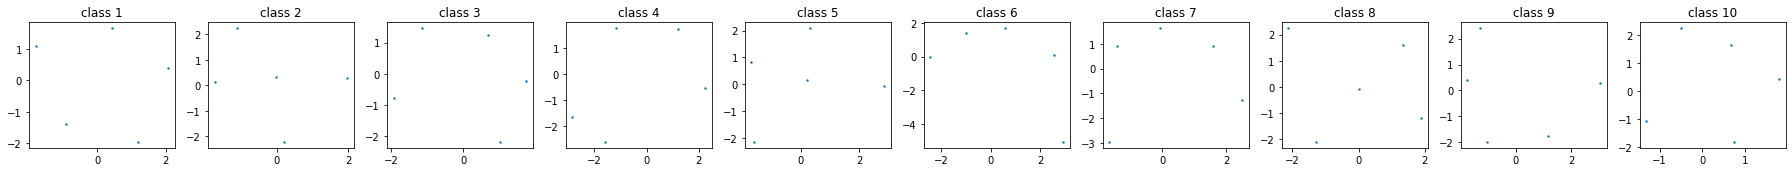

In [10]:
figure(tight_layout=True, figsize=(2.5 * n_classes, 2.5))
with torch.no_grad():
    for i, (vae, X) in enumerate(zip(vae_per_label, train_per_label), start=1):
        z = vae.encoder(torch.FloatTensor(X))[0]
        # plot
        subplot(1, n_classes, i)
        if z.shape[1] == 1:
            scatter(z, torch.zeros_like(z), s=2)
        elif z.shape[1] == 2:
            scatter(*z.T, s=2)
        else:
            scatter(*PCA(2).fit_transform(z).T, s=2)
        title(f"class {i}")
savefig(plot_dir / f"feature_space.pdf")
show()

#### Visualize some generated images

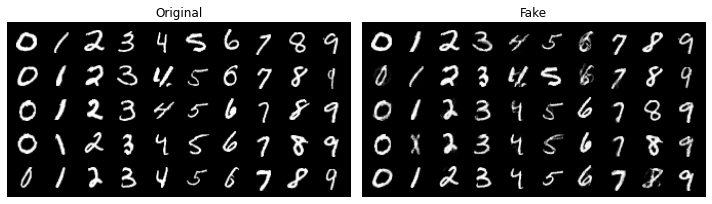

In [11]:
# original images
orig_img = torch.FloatTensor(np.concatenate([X[:10] for X in train_per_label], axis=0))
# generate new examples from normal distribution
z_rand = torch.empty(min(n_originals_per_class, 10), vae_z_dim).normal_(0, 1)
with torch.no_grad():
    x_gen_per_class = torch.cat([
        vae.decoder.forward(z_rand).detach()
        for vae in vae_per_label
    ], dim=0)

# plot original and fake images
figure(tight_layout=True, figsize=(10, 5))
subplot(121)
axis("off")
title("Original")
imshow(
    np.transpose(
        vutils.make_grid(orig_img[ordering(min(n_originals_per_class, 10), n_classes)], padding=5, normalize=True, nrow=10),
        (1, 2, 0),
    ),
)
subplot(122)
axis("off")
title("Fake")
imshow(
    np.transpose(
        vutils.make_grid(x_gen_per_class[ordering(min(n_originals_per_class, 10), n_classes)], padding=5, normalize=True, nrow=10),
        (1, 2, 0),
    ),
)
savefig(plot_dir / "original-fake.pdf")
show()

## Generative Classifier

In [12]:
class GenerativeClassifier(nn.Module):
    def __init__(self):
        super(GenerativeClassifier, self).__init__()
        self.conv1 = nn.Conv2d(1, 2, kernel_size=5)
        self.conv2 = nn.Conv2d(2, 4, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(4 * 4 * 4, 8)
        self.fc2 = nn.Linear(8, 1)
    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 4 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return torch.sigmoid(x)

### Generating the data for GC Training

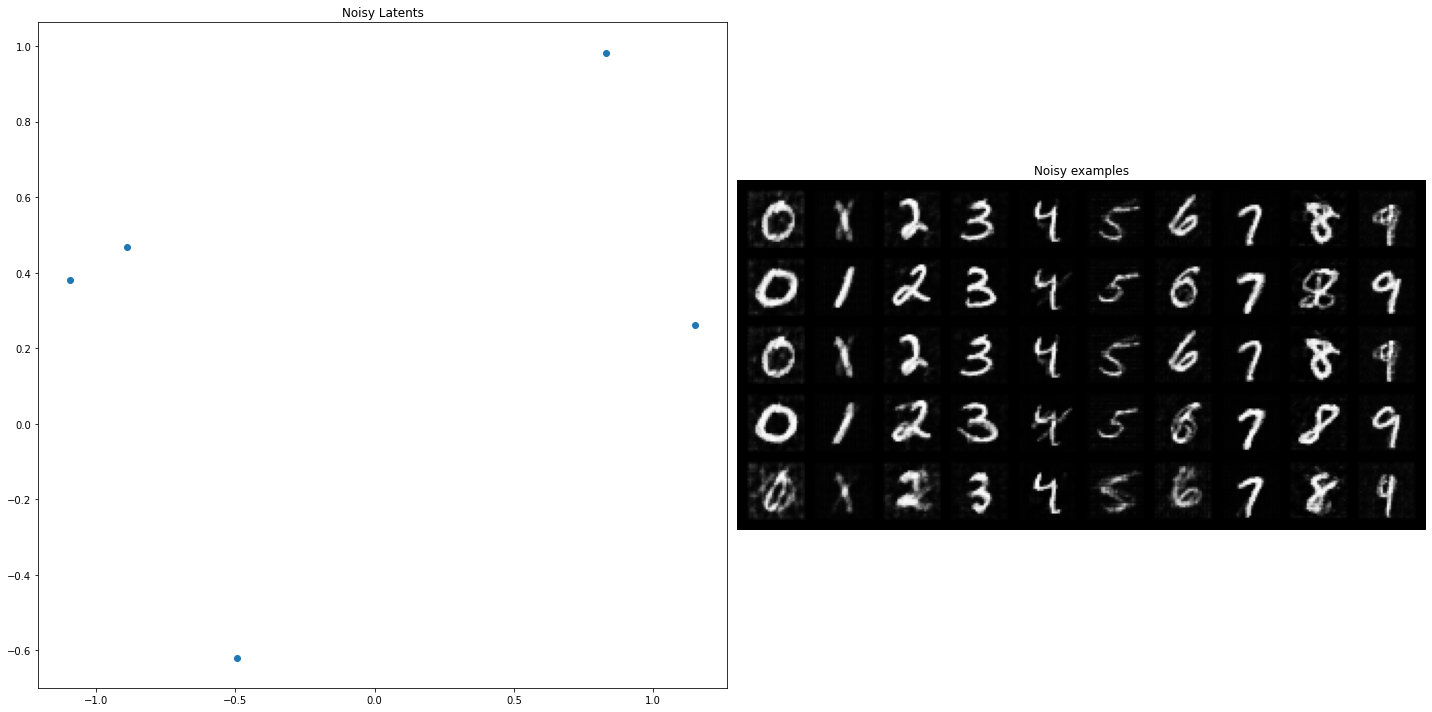

In [13]:
# seed before generating the noisy examples for training the generative classifier
seed_everything(data_seed)

# build dataset of fake and real samples
real_x = torch.FloatTensor(np.concatenate(train_per_label, axis=0))
with torch.no_grad():
    # create random latents outside the normal distribution (0, 1)
    # phi = np.random.uniform(-2*np.pi, 2*np.pi, size=(n_originals_per_class,))
    # rho = np.random.normal(0, 1, size=(n_originals_per_class,))
    # z_rand = torch.FloatTensor([rho * np.cos(phi), rho * np.sin(phi)]).T
    z_rand = torch.empty((n_originals_per_class, vae_z_dim)).normal_(0, 1)
    fake_x = torch.cat([
        vae.decoder.forward(z_rand)
        for vae in [*zip(*early_vae_per_label)][(gc_step_threshold - 300) // 50]
    ], dim=0)
    
# create labels
real_y = torch.ones(real_x.size(0))
fake_y = torch.zeros(fake_x.size(0))
# pack into dataset
gc_dataset = torch.utils.data.TensorDataset(
    torch.cat((real_x, fake_x), dim=0),
    torch.cat((real_y, fake_y), dim=0)
)

# visualize the latents used for generating noisy examples
figure(figsize=(20, 10), tight_layout=True)
subplot(121)
title("Noisy Latents")
scatter(*z_rand.T)

subplot(122)
title("Noisy examples")
axis("off")
imshow(
    np.transpose(
        vutils.make_grid(fake_x[:100][ordering(min(n_originals_per_class, 10), n_classes)], padding=5, normalize=True, nrow=10),
        (1, 2, 0),
    ),
)
show()

### Training the Generative Classifier

In [14]:
# seed before training the generative classifier
seed_everything(model_seed)

# train generative classifier
gc = GenerativeClassifier()
gc.to(device).train()
optim = torch.optim.Adam(gc.parameters())

seed_everything(data_seed)
t = trange(gc_training_steps)
for i in t:
    # get batch to train on
    batch_idx = np.random.randint(0, len(gc_dataset), gc_batch_size)
    x, y_hat = gc_dataset[batch_idx]
    # apply model and compute loss
    y = gc.forward(x.to(device)).flatten()
    loss = F.binary_cross_entropy(y, y_hat.to(device))  # + 0.05 * (1 - y).mean()
    # update model parameters
    optim.zero_grad()
    loss.backward()
    optim.step()

# move classifier back to cpu
# and set it into evaluation mode
gc = gc.to('cpu').eval()

  0%|          | 0/2000 [00:00<?, ?it/s]

#### Visualize the behaviour of the Generative Classifier

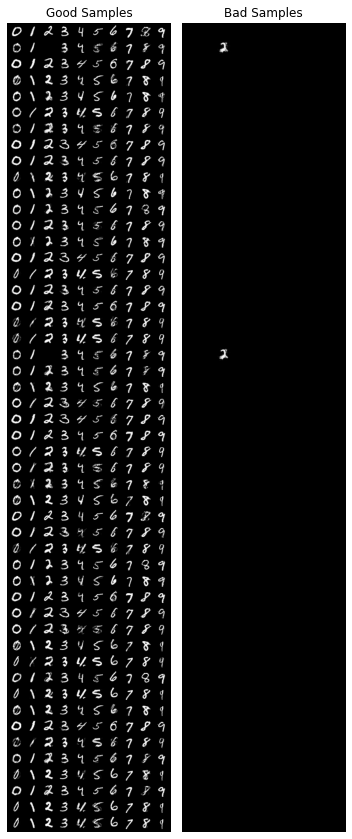

In [15]:
seed_everything(data_seed)
# generate some samples
with torch.no_grad():
    z_rand = torch.empty(50, vae_z_dim).normal_(0, 1)
    x_gen = torch.cat([
        vae.decoder.forward(z_rand)
        for vae in vae_per_label
    ], dim=0)
    # apply generative classifier
    mask = gc.forward(x_gen) > 0.5
# convert to numpy
x_gen = x_gen
mask = mask
# apply mask
x_good, x_bad = x_gen.clone(), x_gen.clone()
x_good[~mask], x_bad[mask] = 0, 0

# visualize the choice of
# the generative classifier
figure(figsize=(5, 13), tight_layout=True)
subplot(121)
axis("off")
title("Good Samples")
imshow(
    np.transpose(
        vutils.make_grid(x_good[ordering(50, n_classes)], padding=5, normalize=True, nrow=10),
        (1, 2, 0),
    ),
)
subplot(122)
axis("off")
title("Bad Samples")
imshow(
    np.transpose(
        vutils.make_grid(x_bad[ordering(50, n_classes)], padding=5, normalize=True, nrow=10),
        (1, 2, 0),
    ),
)
show()

## Classification Task

In [16]:
class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 8, kernel_size=5)
        self.conv2 = nn.Conv2d(8, 16, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(4 * 4 * 16, 64)
        self.fc2 = nn.Linear(64, 10)
    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 4 * 4 * 16)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=-1)

### Training script for the Classification Model

In [17]:
def train_classifier(dataset):
    seed_everything(model_seed)
    # create a cnn model
    model = Classifier()
    # move model to device and set
    # it in train mode
    model.to(device).train()
    optim = torch.optim.Adam(model.parameters())
    # values we want to track
    train_losses, test_losses = [], []
    weighted_f1_scores, acc_scores = [], []
    
    seed_everything(data_seed)
    # train loop
    t = trange(cls_training_steps)
    for i in t:
        # get batch to train from
        x_idx = np.random.randint(0, len(dataset), cls_batch_size)
        x, y_hat = dataset[x_idx]
        # apply model and compute loss
        y = model.forward(x.to(device))
        loss = F.nll_loss(y, y_hat.to(device))
        # update model parameters
        optim.zero_grad()
        loss.backward()
        optim.step()
        # add loss value to list
        train_losses.append(loss.item())

        if (i % cls_eval_interval == 0):
            # evaluate model
            model.eval()
            with torch.no_grad():
                # apply model to test data
                y = model.forward(x_test.to(device))
                loss = F.nll_loss(y, y_test.to(device))
                # add loss to list
                test_losses.append(loss.item())
                # get predictions and compute f1-scores
                y_pred = y.argmax(-1).cpu().numpy()
                weighted_f1_scores.append(f1_score(y_test.numpy(), y_pred, average='weighted'))
                acc_scores.append(accuracy_score(y_test.numpy(), y_pred))
            # back to training the model
            model.train()
    # move model back to cpu and
    # set it to evaluation mode
    model.to('cpu').eval()
    # return model and tracked values
    return model, {
        'train-losses': train_losses, 
        'test-losses':  test_losses, 
        'weighted-f1':  weighted_f1_scores, 
        'acc':          acc_scores
    }

## Training Classification models
Here we train three models, i.e.
 - one trained on only the originally provided (reduced!) dataset
 - one trained on the original together with some generated samples
 - and one where the generated examples are filtered by the generative classifier

### Baseline

  0%|          | 0/1000 [00:00<?, ?it/s]

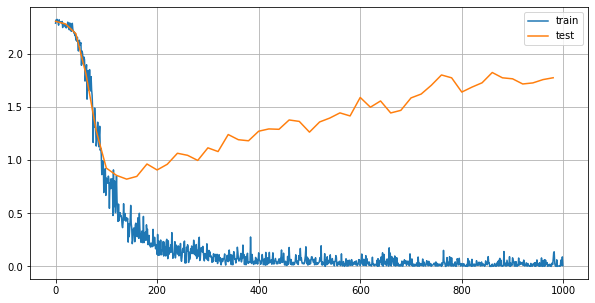

In [18]:
# build dataset of only the original samples
orig_train_dataset = torch.utils.data.TensorDataset(
    torch.FloatTensor(np.concatenate(train_per_label, axis=0)),
    torch.LongTensor(np.concatenate([
        (np.zeros(X.shape[0]) + i) for i, X in enumerate(train_per_label)
    ], axis=0))
)
# train model on dataset
model_orig, metrics_orig = train_classifier(orig_train_dataset)
# plot the losses
figure(figsize=(10, 5))
grid()
plot(metrics_orig['train-losses'], label='train')
ticks = [i * cls_eval_interval for i in range(len(metrics_orig['test-losses']))]
plot(ticks, metrics_orig['test-losses'], label='test')
legend()
savefig(plot_dir / "classifier_loss_orig.pdf")
show()

### With generated data

  0%|          | 0/1000 [00:00<?, ?it/s]

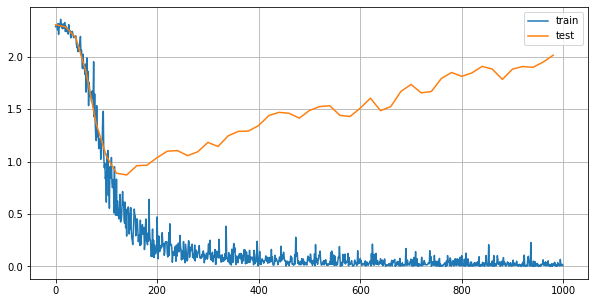

In [19]:
generated_per_label = [gen.numpy() for gen in generate_examples(n_generated_per_class)]
# full_train_x = generated_per_label
# create a combined dataset from the original and generated samples
full_train_x = [
    np.concatenate(both, axis=0)
    for both in zip(train_per_label, generated_per_label)
]
full_train_y = [
    (np.zeros(X.shape[:1]) + i) 
    for i, X in enumerate(full_train_x)
]
# pack all of this in a dataset
full_train_dataset = torch.utils.data.TensorDataset(
    torch.FloatTensor(np.concatenate(full_train_x, axis=0)),
    torch.LongTensor(np.concatenate(full_train_y, axis=0))
)
# train model on both original and generated data
model_gen, metrics_gen = train_classifier(full_train_dataset)
# plot training and test losses
figure(figsize=(10, 5))
grid()
plot(metrics_gen['train-losses'], label='train')
ticks = [i * cls_eval_interval for i in range(len(metrics_gen['test-losses']))]
plot(ticks, metrics_gen['test-losses'], label='test')
legend()
savefig(plot_dir / "classifier_loss_full.pdf")
show()

### With generated data filtered by Generative Classifier

Generated Examples: [5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000]


  0%|          | 0/1000 [00:00<?, ?it/s]

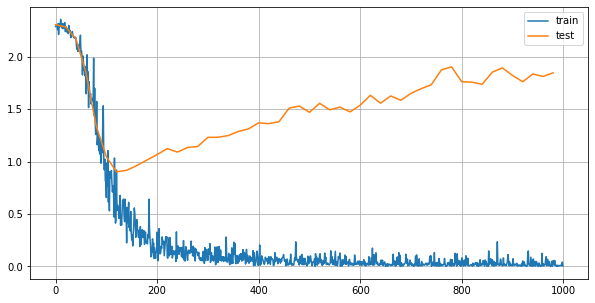

In [20]:
generated_per_label = generate_examples(n_generated_per_class * 10)

gc.to(device)
with torch.no_grad():
    # apply generative classifier
    masks_per_label = [
        gc.forward(x_gen.to(device)).flatten() > 0.5
        for x_gen in generated_per_label
    ]
gc.to('cpu')

generated_per_label = [
    x_gen[mask, ...].numpy()[:n_generated_per_class, ...]
    for x_gen, mask in zip(generated_per_label, masks_per_label)
]
print(f"Generated Examples: {[len(X) for X in generated_per_label]}")

# full_train_x = generated_per_label
# create a combined dataset from the original and generated samples
full_train_x = [
    np.concatenate(both, axis=0)
    for both in zip(train_per_label, generated_per_label)
]
# full_train_x = generated_per_label
full_train_y = [
    (np.zeros(X.shape[:1]) + i) 
    for i, X in enumerate(full_train_x)
]
# pack all of this in a dataset
full_train_dataset = torch.utils.data.TensorDataset(
    torch.FloatTensor(np.concatenate(full_train_x, axis=0)),
    torch.LongTensor(np.concatenate(full_train_y, axis=0))
)
# train model on both original and generated data
model_gen_gc, metrics_gen_gc = train_classifier(full_train_dataset)
# plot training and test losses
figure(figsize=(10, 5))
grid()
plot(metrics_gen_gc['train-losses'], label='train')
ticks = [i * cls_eval_interval for i in range(len(metrics_gen_gc['test-losses']))]
plot(ticks, metrics_gen_gc['test-losses'], label='test')
legend()
show()

## Evaluating the Models

In [21]:
df_results = pd.DataFrame.from_dict({
    "model_seed": [model_seed],
    "data_seed": [data_seed],
    "mix_data": [mix_data],
    "n_originals_per_class": [n_originals_per_class],
    "n_generated_per_class": [n_generated_per_class],
    "vae_z_dim": [vae_z_dim],
    "vae_training_steps": [vae_training_steps],
    "vae_beta": [vae_beta],
    "vae_batch_size": [vae_batch_size],
    "gc_training_steps": [gc_training_steps],
    "gc_batch_size": [gc_batch_size],
    "gc_step_threshold": [gc_step_threshold],
    "cls_training_steps": [cls_training_steps],
    "cls_batch_size": [cls_batch_size],
    "cls_eval_interval": [cls_eval_interval],
    "f1-orig": [round(max(metrics_orig["weighted-f1"]), 4)],
    "f1-gen": [round(max(metrics_gen["weighted-f1"]), 4)],
    "f1-gen+gc": [round(max(metrics_gen_gc["weighted-f1"]), 4)],
    "acc-orig": [round(max(metrics_orig["acc"]), 4)],
    "acc-gen": [round(max(metrics_gen["acc"]), 4)],
    "acc-gen+gc": [round(max(metrics_gen_gc["acc"]), 4)],
})

### Comparison of the accuracy

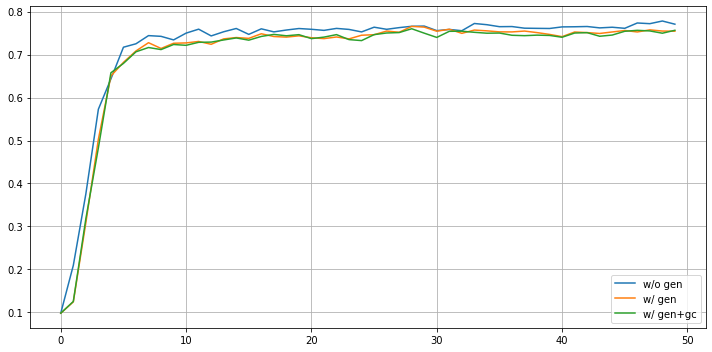

,acc-orig,acc-gen,acc-gen+gc
0,0.7782,0.7657,0.7602


In [22]:
# also plot
figure(tight_layout=True, figsize=(10, 5))
grid()
plot(metrics_orig["acc"], label="w/o gen")
plot(metrics_gen["acc"], label="w/ gen")
plot(metrics_gen_gc["acc"], label="w/ gen+gc")
legend()
savefig(plot_dir / "accuracies_graph.pdf")
show()
df_results[["acc-orig", "acc-gen", "acc-gen+gc"]]

### Comparison of the F1-Scores

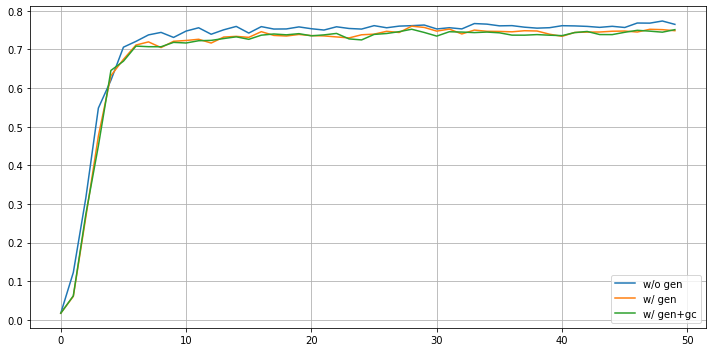

,f1-orig,f1-gen,f1-gen+gc
0,0.7735,0.7602,0.7523


In [23]:
# also plot
figure(tight_layout=True, figsize=(10, 5))
grid()
plot(metrics_orig["weighted-f1"], label="w/o gen")
plot(metrics_gen["weighted-f1"], label="w/ gen")
plot(metrics_gen_gc["weighted-f1"], label="w/ gen+gc")
legend()
savefig(plot_dir / "weighted_f1_graph.pdf")
show()
df_results[["f1-orig", "f1-gen", "f1-gen+gc"]]

## Save Results to disk

In [24]:
# append results to csv file
results_path = plot_root / "results.csv"
if results_path.exists():
    df_saved = pd.read_csv(results_path, index_col=0, header=None).T
    df_results = pd.concat([df_saved, df_results])
df_results.T.to_csv(results_path, header=False)

In [25]:
# save the notebook and export html file to plot directory
import time
from IPython.display import display, Javascript
import hashlib

def save_notebook(file_path):
    start_md5 = hashlib.md5(open(file_path,'rb').read()).hexdigest()
    display(Javascript('IPython.notebook.save_checkpoint();'))
    current_md5 = start_md5
    
    while start_md5 == current_md5:
        time.sleep(1)
        current_md5 = hashlib.md5(open(file_path,'rb').read()).hexdigest()

from nbconvert import HTMLExporter
import codecs
import nbformat

notebook_name = 'MNIST-MULTI.ipynb'
output_file_name = plot_dir / 'output.html'

save_notebook(notebook_name)

exporter = HTMLExporter()
output_notebook = nbformat.read(notebook_name, as_version=4)

output, resources = exporter.from_notebook_node(output_notebook)
codecs.open(output_file_name, 'w', encoding='utf-8').write(output)

<IPython.core.display.Javascript object>